Credit and special thanks to the authors of:
https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
https://towardsdatascience.com/the-most-favorable-pre-trained-sentiment-classifiers-in-python-9107c06442c6
https://medium.com/@b.terryjack/nlp-pre-trained-sentiment-analysis-1eb52a9d742c

# Data Preprocessing
Mainly removing mails, website links, tokenization (splitting words)

In [1]:
import re
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [2]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),     deacc=True))
        
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

def edit_text(text):
    temp = []
    #Splitting pd.Series to list
    data_to_list = [text]
    for i in range(len(data_to_list)):
        temp.append(depure_data(data_to_list[i]))
    data_words = list(sent_to_words(temp))
    data = []
    for i in range(len(data_words)):
        data.append(detokenize(data_words[i]))
    return data[0]

# Flair model initalization

In [3]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2022-07-04 10:16:29,020 loading file C:\Users\csaba\.flair\models\sentiment-en-mix-distillbert_4.pt


# Reddit scraping - PRAW

In [4]:
import praw
import numpy as np
reddit = praw.Reddit(client_id='99_Ndr2MqM1qzNw9dmDhuw', client_secret='VnPejgHX9KFQK6jJuf3mMxZkQruxoA', user_agent='sentiment')

In [5]:
import pickle

with open('lsvc_sarcasm.pickle','rb') as f:
    lsvc = pickle.load(f)
with open('tfidf_sarcasm.pickle','rb') as f:
    tfidf = pickle.load(f)    


In [6]:
url = "https://www.reddit.com/r/news/comments/vjpfbh/supreme_court_overturns_roe_v_wade_states_can_ban/"
n_comments = 100

In [7]:
submission = reddit.submission(url=url)
submission.comments.replace_more(limit=0) # flatten tree
comments = submission.comments.list() # all comments

In [8]:
counts = [0, 0]
counts_sarc=[0, 0]

In [9]:
valsFlair = np.zeros(n_comments)
valsFlair_withSarcasm = np.zeros(n_comments)
for i, top_level_comment in enumerate(comments[:n_comments]):
    s = flair.data.Sentence(edit_text(top_level_comment.body))
    flair_sentiment.predict(s)
    total_sentiment = s.labels
    if len(total_sentiment)==1:
        sarcasm = lsvc.predict(tfidf.transform([top_level_comment.body]))[0]
        #print(top_level_comment.body + '\n' + str(total_sentiment[0].value)+'' '+str(sarcasm)+' '+ str(total_sentiment[0].score)+ '\n')
        result = total_sentiment[0].value
        
        if (result=='NEGATIVE'):
            valsFlair[i]=-1
            counts[0]+=1
            if sarcasm==1:
                valsFlair_withSarcasm[i]=1
                counts_sarc[1]+=1
            else:
                valsFlair_withSarcasm[i]=-1
                counts_sarc[0]+=1
        elif (result=='POSITIVE'):
            valsFlair[i]=1 
            counts[1]+=1
            if sarcasm==1:
                valsFlair_withSarcasm[i]=-1
                counts_sarc[0]+=1
            else:
                valsFlair_withSarcasm[i]=1
                counts_sarc[1]+=1

# Visualisation

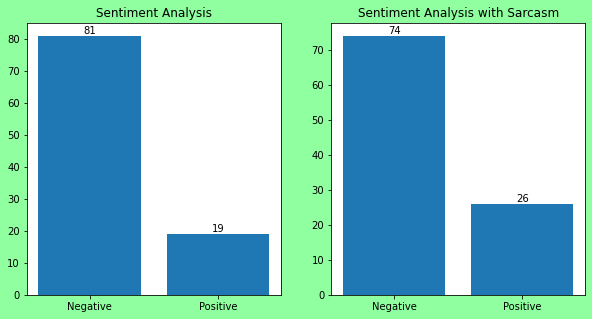

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

bars1=ax1.bar(['Negative', 'Positive'], counts)
bars2=ax2.bar(['Negative', 'Positive'], counts_sarc)
ax1.bar_label(bars1)
ax2.bar_label(bars2)
fig.patch.set_facecolor('xkcd:mint green')
ax1.title.set_text("Sentiment Analysis")
ax2.title.set_text("Sentiment Analysis with Sarcasm")